# Imports

In [1]:
# %matplotlib widget
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, MFCC

# Loading Data and Creating Dataset Class

- `train_audio/`: short recordings of individual species with labels - *supervised learning*
- `train_soundscapes/`: long recordings without labels - *unsupervised learning*
- `train.csv`: metadata for the training audio


In [2]:
# loading metadata

metadata_path = "data/train.csv"

metadata = pd.read_csv(metadata_path)

print(f"There are {len(metadata['primary_label'].unique())} different species recorded in the train_audio folder.")
print(f"There are a total of {len(metadata)} recordings.")

There are 206 different species recorded in the train_audio folder.
There are a total of 28564 recordings.


### Create a Dataset Class

This class will help us collect the data into a single object, as well as create a label dictionary. Now, each species will be labeled with an integer from 0 to 205.

In [3]:
import os
from mutagen.oggvorbis import OggVorbis
from tinytag import TinyTag

def get_audio_metadata(file_path: str) -> dict:
    """Extracts all audio metadata at once (file size, duration, bitrate, etc.)."""
    tag = TinyTag.get(file_path)
    
    file_size = os.path.getsize(file_path)
    duration = tag.duration  # Duration in seconds
    audio = OggVorbis(file_path)
    bitrate = audio.info.bitrate // 1000  # Convert from bps to kbps
    sample_rate = audio.info.sample_rate
    channels = audio.info.channels
    codec = audio.mime[0] if audio.mime else "Unknown"

    return {
        "file_size": file_size,
        "audio_duration": duration,
        "audio_bitrate": bitrate,
        "audio_sample_rate": sample_rate,
        "audio_channels": channels,
        "audio_codec": codec
    }


In [4]:
def load_audio_data(audio_dir: str) -> pd.DataFrame:
    """Constructs a DataFrame from the files 
    in the audio_dir path"""
    
    data_rows = []  # temp list
    for root, _, files in os.walk(audio_dir):
        for file in files:
            if file.endswith(".ogg"):
                primary_label = os.path.splitext(file)[0]
                data_rows.append({
                                    "primary_label": primary_label, 
                                    "filename": file
                                    })
    
    return pd.DataFrame(data_rows)


class AudioDataset(Dataset):
    def __init__(self, datafolder:str="data", metadata_csv: str="train.csv", audio_dir: str="train_audio", transform: MelSpectrogram=None, metadata: bool=False):
        """
        metadata_csv: path to train.csv
        audio_dir: path to train_audio/
        transform: transform for waveform
        """
        datafolder = datafolder + "/"
        audio_dir = audio_dir + "/"
        
        self.audio_dir = datafolder + audio_dir
        self.transform = transform
        
        if metadata_csv == "":
            self.data = load_audio_data(self.audio_dir)
        else:
            self.data = pd.read_csv(datafolder + metadata_csv)
            
        if metadata:
            metadata_df = self.data["filename"].apply(lambda filename: get_audio_metadata(self.audio_dir + filename))
            # Unpack the dictionary and assign to new columns
            metadata_df = pd.DataFrame(metadata_df.tolist())
            self.data = pd.concat([self.data, metadata_df], axis=1)


        # sort by alphabetical order, then map species name to label index
        self.classes = sorted(self.data["primary_label"].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get metadata row of specified index
        row = self.data.iloc[idx]

        # construct path to audio file
        audio_path = self.audio_dir + row["filename"]
        try:
            waveform, sample_rate = torchaudio.load(audio_path)
        except:
            print(f"Error loading {audio_path}")
            return torch.zeros(1, 16000), -1 # dummy data if missing file

        # apply any transformation if specified
        if self.transform:
            waveform = self.transform(waveform)

        # get label
        label = self.class_to_idx[row["primary_label"]]

        return waveform, label

# Exploratory Data Analysis

- histograms
- scatter plots 

In [5]:
# define transform
sample_rate = 8000

mel = MelSpectrogram(sample_rate=sample_rate, n_mels=32)
mfcc = MFCC(sample_rate=sample_rate, n_mfcc=30)

In [6]:
# initialize dataset & dataloader
dataset = AudioDataset(transform=mel, metadata=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

In [7]:
# file metadata
train_metadata = dataset.data.iloc[:, -6:]

train_metadata

,file_size,audio_duration,audio_bitrate,audio_sample_rate,audio_channels,audio_codec
0,770871,98.853375,72,32000,1,audio/vorbis
1,755101,96.537719,72,32000,1,audio/vorbis
2,902788,116.599812,72,32000,1,audio/vorbis
3,823062,105.446313,72,32000,1,audio/vorbis
4,814484,103.631469,72,32000,1,audio/vorbis
...,...,...,...,...,...,...
28559,29598,3.392000,72,32000,1,audio/vorbis
28560,61987,7.659688,72,32000,1,audio/vorbis
28561,63164,7.666656,72,32000,1,audio/vorbis
28562,197867,27.036750,72,32000,1,audio/vorbis


In [8]:
# initialize dataset & dataloader
scape = AudioDataset(metadata_csv="", audio_dir="train_soundscapes", transform=mel, metadata=True)
dataloader_scape = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

In [9]:
dataset.data.to_csv("data/dataset.df")
scape.data.to_csv("data/scape.df")

In [10]:
scape_metadata = scape.data.iloc[:, 2:]
scape_metadata

,file_size,audio_duration,audio_bitrate,audio_sample_rate,audio_channels,audio_codec
0,466860,60.0,72,32000,1,audio/vorbis
1,491965,60.0,72,32000,1,audio/vorbis
2,474773,60.0,72,32000,1,audio/vorbis
3,492253,60.0,72,32000,1,audio/vorbis
4,497865,60.0,72,32000,1,audio/vorbis
...,...,...,...,...,...,...
9721,472634,60.0,72,32000,1,audio/vorbis
9722,495270,60.0,72,32000,1,audio/vorbis
9723,494012,60.0,72,32000,1,audio/vorbis
9724,474657,60.0,72,32000,1,audio/vorbis


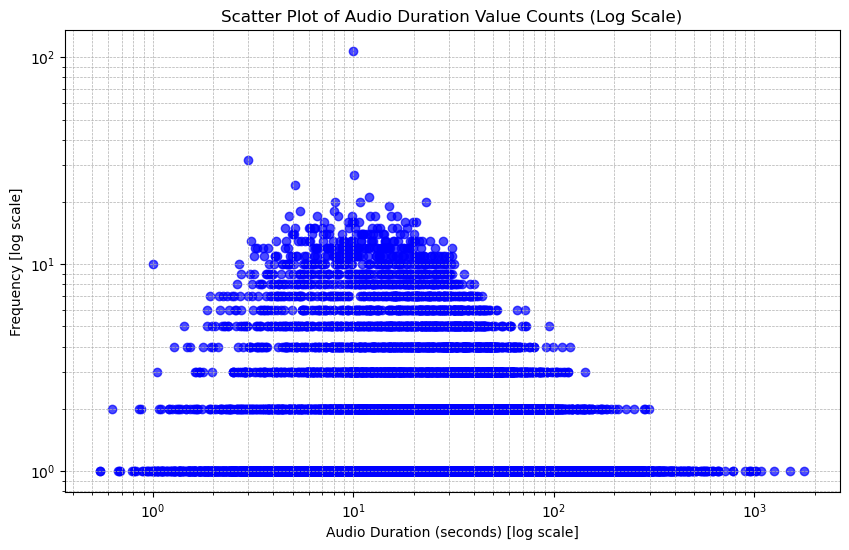

In [11]:
import matplotlib.pyplot as plt

def plot_value_counts(data: pd.Series):
    values = data.value_counts()

    plt.figure(figsize=(10, 6))
    plt.scatter(values.index, values.values, color='blue', alpha=0.7)

    plt.title('Scatter Plot of Audio Duration Value Counts (Log Scale)')
    plt.xlabel('Audio Duration (seconds) [log scale]')
    plt.ylabel('Frequency [log scale]')

    plt.xscale('log')
    plt.yscale('log')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.show()

plot_value_counts(train_metadata["audio_duration"])

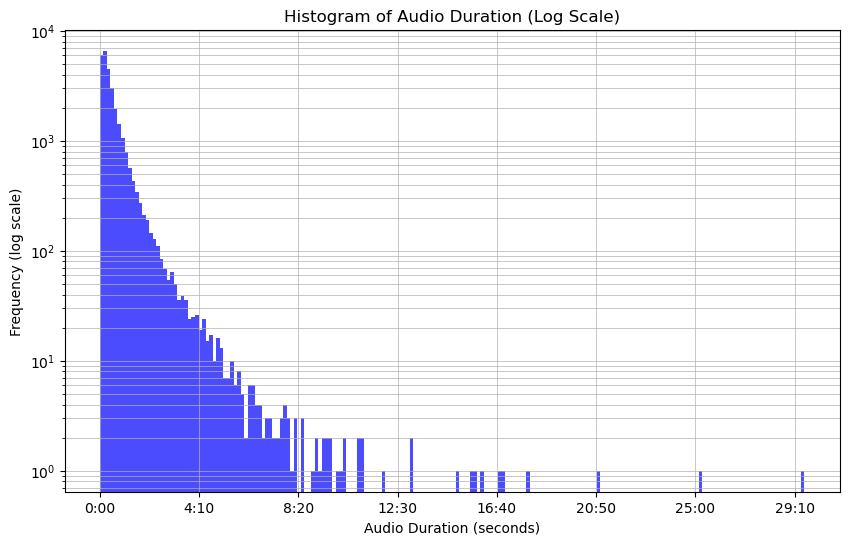

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def format_duration(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f'{minutes}:{seconds:02d}'

def plot_value_histograms(data: pd.Series, bins:int=200):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color='blue', alpha=0.7, log=True)

    plt.title('Histogram of Audio Duration (Log Scale)')
    plt.xlabel('Audio Duration (seconds)')
    plt.ylabel('Frequency (log scale)')

    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_duration))

    plt.grid(True, which='both', linestyle='-', linewidth=0.5)
    plt.show()

plot_value_histograms(train_metadata["audio_duration"])

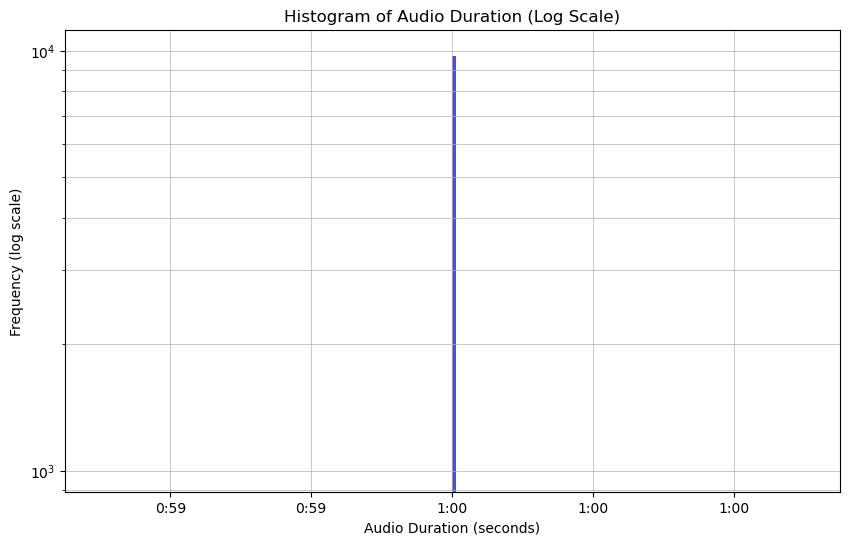

In [13]:
plot_value_histograms(scape_metadata["audio_duration"], 200)

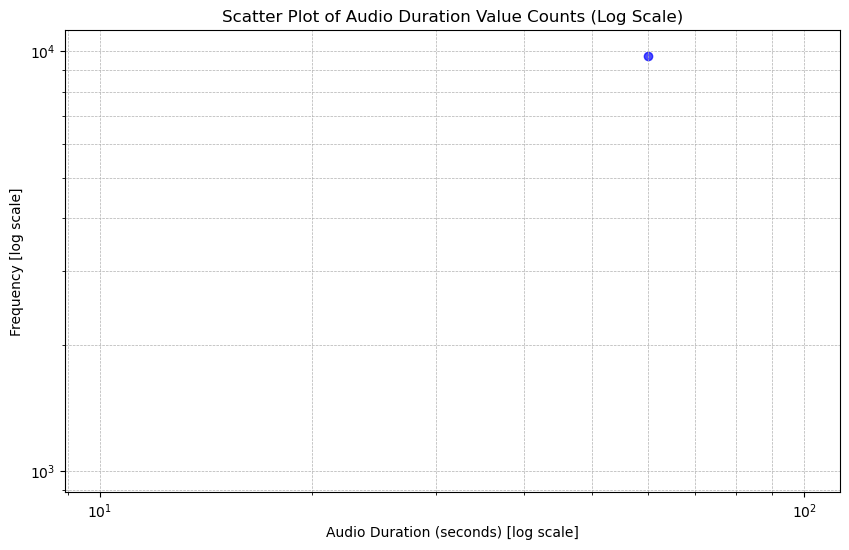

In [14]:
plot_value_counts(scape_metadata["audio_duration"])

In [15]:
def print_unique(data: pd.DataFrame):
    for col in data.columns:
        print(col, "has unique values:", data[col].unique())
        
print_unique(train_metadata[train_metadata.columns[2:]])

audio_bitrate has unique values: [72]
audio_sample_rate has unique values: [32000]
audio_channels has unique values: [1]
audio_codec has unique values: ['audio/vorbis']


In [16]:
print_unique(train_metadata[scape_metadata.columns[2:]])

audio_bitrate has unique values: [72]
audio_sample_rate has unique values: [32000]
audio_channels has unique values: [1]
audio_codec has unique values: ['audio/vorbis']


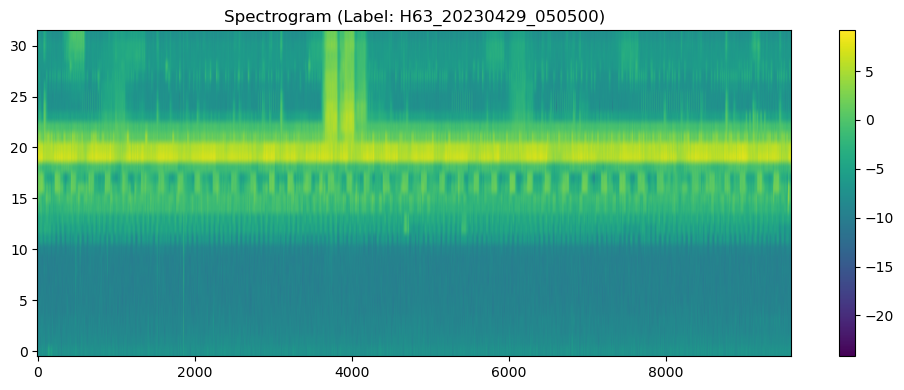

In [17]:
from typing import Optional

def spectrogram(dataset, index: int, clusters: Optional[pd.Series] = None, cmap='tab10'):
    waveform, label = dataset[index]
    spec = waveform.squeeze(0).log2().detach().numpy()  # Shape: (freq_bins, time_frames)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(spec, aspect='auto', origin='lower')
    plt.title(f"Spectrogram (Label: {dataset.classes[label]})")
    plt.colorbar(im, ax=ax)

    # Optional: overlay color bands based on clustering
    if clusters is not None:
        if not isinstance(clusters, pd.Series):
            raise ValueError("clusters must be a pandas Series")
        
        x_len = spec.shape[1]
        cluster_labels = clusters.reindex(range(x_len), method='nearest')
        cluster_labels = cluster_labels.bfill().ffill().astype(int)

        unique_clusters = sorted(cluster_labels.unique())
        colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(unique_clusters)))
        color_map = dict(zip(unique_clusters, colors))
        
        for x in range(x_len):
            cluster_id = cluster_labels.iloc[x]
            ax.axvspan(x - 0.5, x + 0.5, ymin=0, ymax=0.1, color=color_map[cluster_id], linewidth=0)

    plt.tight_layout()
    plt.show()
    
spectrogram(scape, 12)

In [18]:
waveform, label = dataset[12]
df = pd.DataFrame(waveform.squeeze(0).detach().numpy()).T
print(df.shape)

(3627, 32)


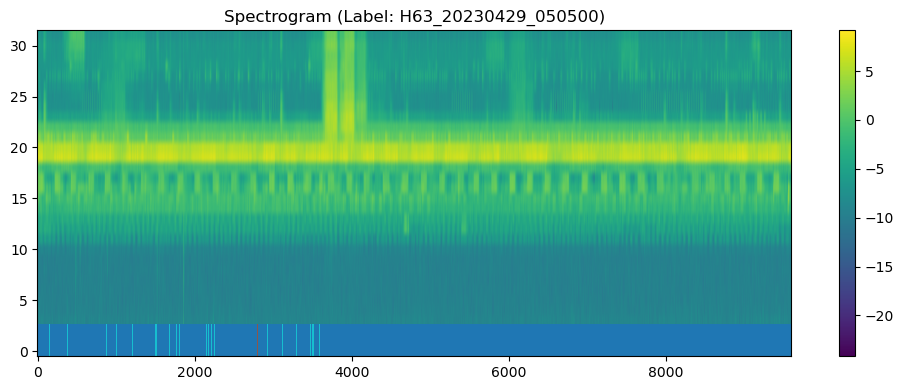

In [19]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

def run_clustering(
    df: pd.DataFrame,
    method: str = 'kmeans',
    n_clusters: int = 3,
    **kwargs
) -> pd.Series:
    """
    Run clustering on a DataFrame and return a Series of cluster labels.
    
    Parameters:
        df (pd.DataFrame): The input features.
        method (str): Clustering method - 'kmeans', 'dbscan', or 'agglomerative'.
        n_clusters (int): Number of clusters (ignored for DBSCAN).
        **kwargs: Additional parameters to pass to the clustering algorithm.
    
    Returns:
        pd.Series: Cluster labels indexed the same as the input DataFrame.
    """
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42, **kwargs)
    elif method == 'dbscan':
        model = DBSCAN(**kwargs)
    elif method == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters, **kwargs)
    else:
        raise ValueError(f"Unsupported clustering method: {method}")
    
    labels = model.fit_predict(df)
    return pd.Series(labels, index=df.index, name='cluster')

cl = run_clustering(df, 'agglomerative', linkage='ward')
spectrogram(scape, 12, cl)

In [20]:
# remove rows where any column has a value which is an outlier by >3 STD over the column
k = 4
df_means = df.mean()
df_std_devs = df.std()
outliers = ((df - df_means).abs() > (k * df_std_devs)).any(axis=1)

# Remove rows with any outliers
df = df[~outliers]
print(outliers.sum(), "outliers are excluded")

306 outliers are excluded


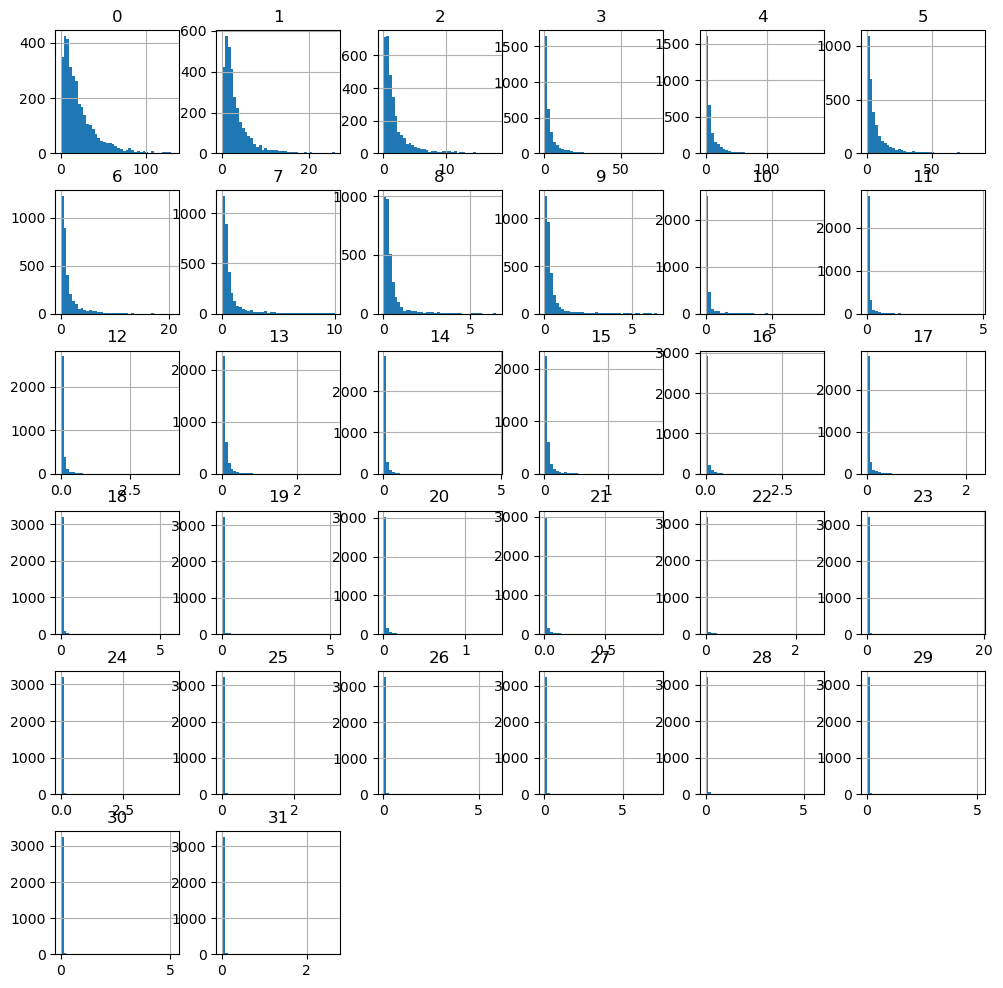

In [21]:
fig = df.hist(figsize=(12, 12), bins=40)

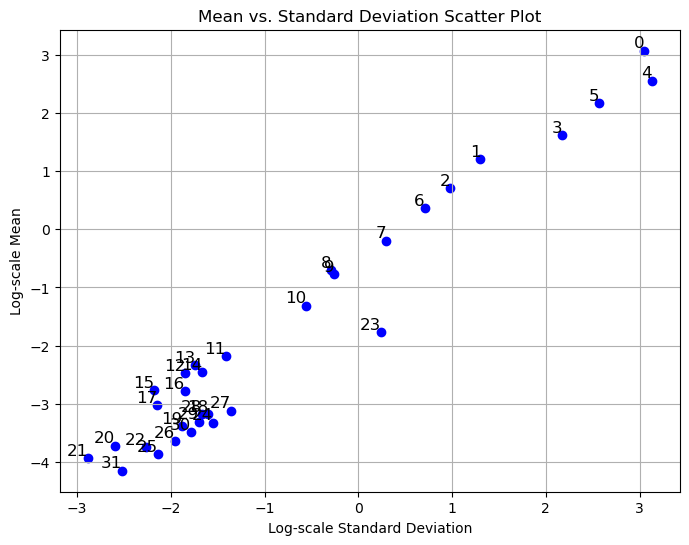

In [22]:
def plot_mean_std(df: pd.DataFrame, log_map=False):
    """Computes the mean and standard deviation for each column
    and plots the two in a scatterplot with labelled axes"""
    means = df.mean()
    std_devs = df.std()
    
    if log_map:
        epsilon = 0.005
        means = np.log(means.abs() + epsilon)
        std_devs = np.log(std_devs + epsilon)

    plt.figure(figsize=(8, 6))
    plt.scatter(std_devs, means, color='b')
    
    for col in df.columns:
        plt.text(std_devs[col], means[col], col, fontsize=12, ha='right', va='bottom')

    plt.ylabel("Log-scale Mean" if log_map else "Mean")
    plt.xlabel("Log-scale Standard Deviation" if log_map else "Standard Deviation")
    plt.title("Mean vs. Standard Deviation Scatter Plot")
    plt.grid(True)

    # Show plot
    plt.show()


plot_mean_std(df[df.columns], True)


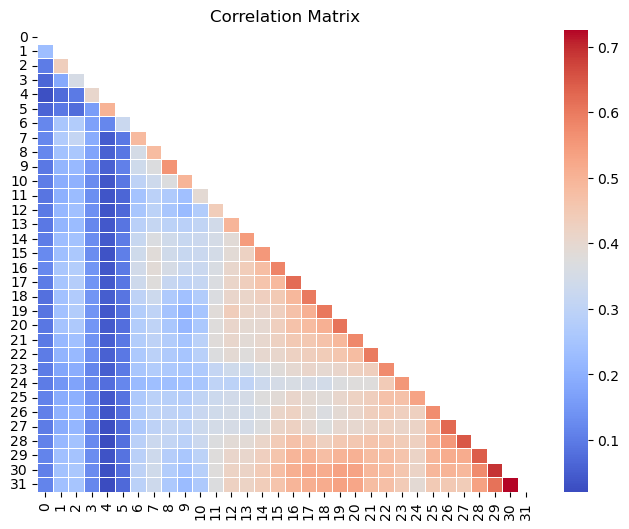

In [23]:
import seaborn as sns

corr_matrix = df.corr(method='kendall')

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, mask=mask, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [24]:
import umap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

scaled_df = StandardScaler().fit_transform(df)

reducer = umap.UMAP(
    n_neighbors=200,
    min_dist=0.1,
    n_components=3,
    metric='chebyshev'
)
embedding = reducer.fit_transform(scaled_df)
embedding.shape

/usr/local/Caskroom/miniconda/base/envs/birdCLEF/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(3321, 3)

In [30]:
cl_filtered = cl[df.index]

Text(0.5, 1.0, 'UMAP projection of the dataset')

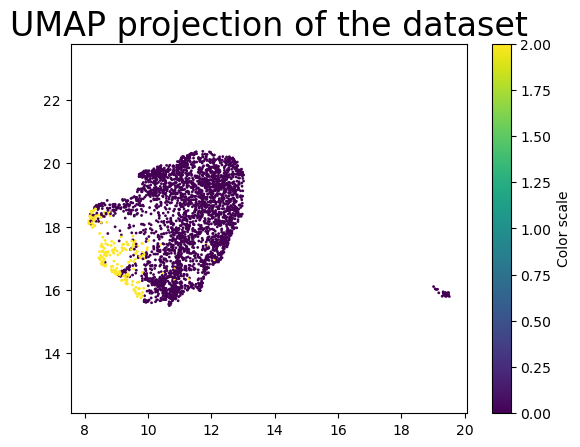

In [31]:
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1], 
    s=1, 
    c=cl_filtered)

cbar = plt.colorbar(scatter)
cbar.set_label("Color scale")  

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24)

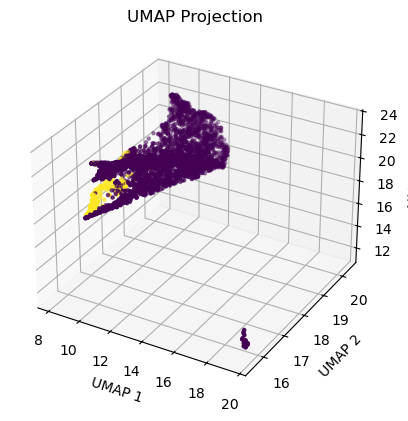

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=cl_filtered, s=5)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP Projection')
plt.show()